In [2]:
from __future__ import annotations
import jijmodeling as jm
import jijmodeling_transpiler.core as jtc
import jijmodeling_transpiler_quantum.core as jtqc
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jq_qu

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import matplotlib.pyplot as plt

import openjij as oj

import numpy as np
import matplotlib.pyplot as plt

# from util import *

from itertools import product, islice
from dwave_qbsolv import QBSolv
import math
import copy

from dwave.samplers import SteepestDescentSampler #, SimulatedAnnealingSampler
from neal import SimulatedAnnealingSampler
from tabu import TabuSampler


In [3]:
## Precalculate some important data to form the QUBO 


np.set_printoptions(precision=5)

loc_num = 16
log2loc_num = math.ceil(np.log2(loc_num))
required_qubo_size = int(loc_num*log2loc_num + loc_num*0.5*(log2loc_num)*(log2loc_num-1))
print("required_qubo_size = ", required_qubo_size)
binary_vectors = [list(i) for i in list(product([0, 1], repeat=log2loc_num))]
binary_vectors = np.array([np.array(i) for i in binary_vectors])
print("binary_vectors = \n", binary_vectors)
encoding_bias = [1] + [0 for i in range(2**log2loc_num-1)]
A_matrix = binary_vectors @ binary_vectors.T + encoding_bias
A_matrix_pinv = np.linalg.pinv(A_matrix)

# binary encoding overflow
for i in range(2**log2loc_num):
    for j in range(2**log2loc_num):
        if i >= loc_num and j >= loc_num:
            A_matrix_pinv[i][j] = 0 
            
# print( A_matrix @ A_matrix_pinv)

normalized_sum = 0
normalized_sum_loc = 0

for i in range(loc_num):
    normalized_sum += (((binary_vectors[i] @ binary_vectors.T + encoding_bias) @ A_matrix_pinv)**2 )[0]
    #print(normalized_sum)
for i in range(loc_num):#2**log2loc_num):
    normalized_sum_loc += (((binary_vectors[0] @ binary_vectors.T + encoding_bias) @ A_matrix_pinv)**2 )[i]
    print(normalized_sum_loc)
    
print(normalized_sum_loc)
print(normalized_sum)


# encoding transformation : 
for i in range(loc_num):
    print(
        ((binary_vectors[i] @ binary_vectors.T @ A_matrix_pinv + encoding_bias @ A_matrix_pinv) ) ** 2
    )

phi_data = binary_vectors.T @ A_matrix_pinv
psi_data =  encoding_bias @ A_matrix_pinv
print("phi_data = \n", phi_data)
print("psi_data = \n", psi_data)

required_qubo_size =  160
binary_vectors = 
 [[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
0.09765625000000007
0.1328125000000001
0.16796875000000017
0.17187500000000017
0.20703125000000022
0.21093750000000022
0.21484375000000022
0.21875000000000022
0.2539062500000003
0.2578125000000003
0.2617187500000003
0.2656250000000003
0.2695312500000003
0.2734375000000003
0.2773437500000003
0.31250000000000033
0.31250000000000033
0.3125000000000002
[0.09766 0.03516 0.03516 0.00391 0.03516 0.00391 0.00391 0.00391 0.03516
 0.00391 0.00391 0.00391 0.00391 0.00391 0.00391 0.03516]
[0.03516 0.09766 0.00391 0.03516 0.00391 0.03516 0.00391 0.00391 0.00391
 0.03516 0.00391 0.00391 0.00391 0.00391 0.03516 0.00391]
[0.03516 0.00391 0.09766 0.03516 0.00391 0.00391 0.03516 0.00391 0.00391
 0.00391 0.03516 0.00391 0.00391 0.03516 0.00391 0.00391]
[0.00391 0.03516 0.03516 0.09766 0

In [14]:
for i in range(loc_num):
    print(
        ((binary_vectors[i] @ binary_vectors.T @ A_matrix_pinv + encoding_bias @ A_matrix_pinv) ) ** 20
    )


[7.88861e-11 2.88420e-15 2.88420e-15 8.27181e-25 2.88420e-15 8.27181e-25
 8.27181e-25 8.27181e-25 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25
 8.27181e-25 8.27181e-25 8.27181e-25 2.88420e-15]
[2.88420e-15 7.88861e-11 8.27181e-25 2.88420e-15 8.27181e-25 2.88420e-15
 8.27181e-25 8.27181e-25 8.27181e-25 2.88420e-15 8.27181e-25 8.27181e-25
 8.27181e-25 8.27181e-25 2.88420e-15 8.27181e-25]
[2.88420e-15 8.27181e-25 7.88861e-11 2.88420e-15 8.27181e-25 8.27181e-25
 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25 2.88420e-15 8.27181e-25
 8.27181e-25 2.88420e-15 8.27181e-25 8.27181e-25]
[8.27181e-25 2.88420e-15 2.88420e-15 7.88861e-11 8.27181e-25 8.27181e-25
 8.27181e-25 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25 2.88420e-15
 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25]
[2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25 7.88861e-11 2.88420e-15
 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25 8.27181e-25 2.88420e-15
 2.88420e-15 8.27181e-25 8.27181e-25 8.27181e-25]
[8.27181e-25 2.88420

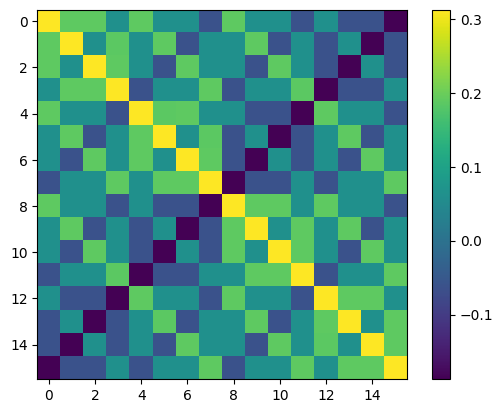

In [23]:
plt.imshow((A_matrix @ A_matrix_pinv)**1)
plt.colorbar()

In [8]:
print(encoding_bias)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
from geopy.distance import geodesic


def geo_dis_cal(sol_res):
    total_distance = 0
    for i_ in range(len(sol_res)-1):
        # print("location ", sol_res[i_], sol_res[i_+1])
        total_distance += geodesic(
            (x_pos[sol_res[i_]], y_pos[sol_res[i_]]),
            (x_pos[sol_res[i_+1]], y_pos[sol_res[i_+1]])).kilometers
        
    return total_distance

def generate_random_instance(n,  X_range, Y_range):
    x_pos = [np.random.randint(0, X_range) for _ in range(n)]
    y_pos = [np.random.randint(0, Y_range) for _ in range(n)]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    
    return x_pos, y_pos, distance



def generate_burma14_instance():
    # 14 cities 
    # optimal: 3323 
    # https://www.researchgate.net/publication/43518652_Dynamic_Ant_Colony_Optimisation
    
    x_pos = [16.47, 16.47, 20.09, 22.39, 25.23, 22.00, 20.47, 17.20, 16.30, 14.05, 16.53, 21.52, 19.41, 20.09]
    y_pos = [96.10, 94.44, 92.54, 93.37, 97.24, 96.05, 97.02, 96.29, 97.38, 98.12, 97.38, 95.59, 97.13, 94.55] 
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distances = np.zeros((14, 14))
    for i in range(14):
        for j in range(i+1, 14):
            distances[i][j] = geodesic(
            (x_pos[i], y_pos[i]),
            (x_pos[j], y_pos[j])).kilometers /100 
            distances[j][i] = distances[i][j]
                
    return x_pos, y_pos, distances

def generate_p01_instance():
    # 15 cities 
    # optimal: 291
    # https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html
    
    x_pos = [] 
    y_pos = [] 
    distances = np.array([
        [ 0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
        [29,  0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
        [82, 55,  0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
        [46, 46, 68,  0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
        [68, 42, 46, 82,  0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
        [52, 43, 55, 15, 74,  0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
        [72, 43, 23, 72, 23, 61,  0, 42, 23, 31, 77, 37, 51, 46, 33],
        [42, 23, 43, 31, 52, 23, 42,  0, 33, 15, 37, 33, 33, 31, 37],
        [51, 23, 41, 62, 21, 55, 23, 33,  0, 29, 62, 46, 29, 51, 11],
        [55, 31, 29, 42, 46, 31, 31, 15, 29,  0, 51, 21, 41, 23, 37],
        [29, 41, 79, 21, 82, 33, 77, 37, 62, 51,  0, 65, 42, 59, 61],
        [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65,  0, 61, 11, 55],
        [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61,  0, 62, 23],
        [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62,  0, 59],
        [46, 21, 51, 64, 23, 59, 33, 37, 11, 37, 61, 55, 23, 59,  0]
        ]) / 100 # should times 100 back later
    return x_pos, y_pos, distances


def generate_ulysses16_instance():
    # 16 cities 
    # optimal: 6859 
    
    x_pos = [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
    y_pos = [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44,  9.10, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    # distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    distances = np.zeros((16, 16))
    for i in range(16):
        for j in range(i+1, 16):
            distances[i][j] = geodesic(
            (x_pos[i], y_pos[i]),
            (x_pos[j], y_pos[j])).kilometers /100 #np.sqrt((x_pos[i] - x_pos[j])**2 + (y_pos[i] - y_pos[j])**2)
            distances[j][i] = distances[i][j]
                
    return x_pos, y_pos, distances

def generate_gr17_instance():
    # 17 cities 
    # optimal: 2085
    # https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html
    
    x_pos = [] 
    y_pos = [] 
    distances = np.array([
        [  0, 633, 257,  91, 412, 150,  80, 134, 259, 505, 353, 324,  70, 211, 268, 246, 121],
        [633,   0, 390, 661, 227, 488, 572, 530, 555, 289, 282, 638, 567, 466, 420, 745, 518],
        [257, 390,   0, 228, 169, 112, 196, 154, 372, 262, 110, 437, 191, 74,  53, 472, 142],
        [ 91, 661, 228,   0, 383, 120,  77, 105, 175, 476, 324, 240,  27, 182, 239, 237,  84],
        [412, 227, 169, 383,   0, 267, 351, 309, 338, 196,  61, 421, 346, 243, 199, 528, 297],
        [150, 488, 112, 120, 267,   0,  63,  34, 264, 360, 208, 329,  83, 105, 123, 364,  35],
        [ 80, 572, 196,  77, 351,  63,   0,  29, 232, 444, 292, 297,  47, 150, 207, 332,  29],
        [134, 530, 154, 105, 309,  34,  29,   0, 249, 402, 250, 314,  68, 108, 165, 349,  36],
        [259, 555, 372, 175, 338, 264, 232, 249,   0, 495, 352,  95, 189, 326, 383, 202, 236],
        [505, 289, 262, 476, 196, 360, 444, 402, 495,   0, 154, 578, 439, 336, 240, 685, 390],
        [353, 282, 110, 324,  61, 208, 292, 250, 352, 154,   0, 435, 287, 184, 140, 542, 238],
        [324, 638, 437, 240, 421, 329, 297, 314,  95, 578, 435,   0, 254, 391, 448, 157, 301],
        [ 70, 567, 191,  27, 346,  83,  47,  68, 189, 439, 287, 254,   0, 145, 202, 289,  55],
        [211, 466,  74, 182, 243, 105, 150, 108, 326, 336, 184, 391, 145,  0,  57, 426,  96],
        [268, 420,  53, 239, 199, 123, 207, 165, 383, 240, 140, 448, 202, 57,   0, 483, 153],
        [246, 745, 472, 237, 528, 364, 332, 349, 202, 685, 542, 157, 289, 426, 483,   0, 336],
        [121, 518, 142,  84, 297,  35,  29,  36, 236, 390, 238, 301,  55, 96, 153, 336,   0]
        ]) / 100 # should times 100 back later
    return x_pos, y_pos, distances




In [8]:
x_pos, y_pos, distance = generate_ulysses16_instance()#generate_random_instance(loc_num, 100, 100)

distance_dict = {}
for ind_i, i in enumerate(distance):
    for ind_j, j in enumerate(i):
        if ind_j > ind_i:
            distance_dict[(ind_i, ind_j)] = distance[ind_i][ind_j]

print("x_pos: ", x_pos)
print("y_pos: ", y_pos)
print("distance: ", distance)

x_pos:  [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
y_pos:  [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44, 9.1, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
distance:  [[ 0.       5.18389  4.94337  3.25037 10.36073  7.2752   6.39312  0.79935
  10.24668  7.10512 22.81829  4.63025  4.44186  4.68886  6.23492  1.4505 ]
 [ 5.18389  0.       1.30756  4.53768 15.49878 12.35631 11.35861  5.47195
  14.56729 11.25574 27.73744  9.61513  9.49958  9.83519 11.38298  5.67464]
 [ 4.94337  1.30756  0.       5.14493 15.28981 11.82919 10.75944  5.40589
  13.66873 10.35796 27.01681  9.05895  8.99424  9.41083 11.16558  5.09763]
 [ 3.25037  4.53768  5.14493  0.      11.89848  9.84085  9.18306  2.7679
  13.35794 10.30531 25.39739  7.48769  7.20681  7.21917  7.98988  4.65388]
 [10.36073 15.49878 15.28981 11.89848  0.       4.76752  5.95083 10.03092
   8.69503  8.81868 14.68445  6.91112  6.76128  6.13346  4.12592 10.38332]
 [ 7.

#### Augmented Lagrangian Method  

ALM:  
https://aqc2021.org/poster2/a/A7.pdf?fbclid=IwAR3XR0aVMiBjNm7ciLXKpMSrOiMJXuhNmMRTG19Zm2_Y3A_aIY0NYXTT-sU

Mapping constraints to penalty:  
https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf

In [6]:
def tsp_problem_ALM()-> jm.Problem:
    
    # define variables
    d = jm.Placeholder('D', ndim=2)
    phi = jm.Placeholder('\\phi', ndim=2)
    psi = jm.Placeholder('\\psi', ndim=1)
    
    
    N = d.len_at(0, latex="N") 

    i = jm.Element("i", belong_to=(0, N)) # 
    m = jm.Element("m", belong_to=(0, N)) # 
    k = jm.Element('k', belong_to=(0, N-1)) #
    q = jm.Element('q', belong_to=(0, N-2)) #
    
    j = jm.Element("j", belong_to=(0, log2loc_num)) # 
    l = jm.Element("l", belong_to=(0, log2loc_num)) # 
    n = jm.Element("n", belong_to=(0, log2loc_num)) # 
    p = jm.Element("p", belong_to=(0, log2loc_num)) # 

    alpha = jm.Element('\\alpha', belong_to=(0, N))
    beta = jm.Element('\\beta', belong_to=(0, N))
    x = jm.BinaryVar("x", shape=(N, log2loc_num))
    y = jm.BinaryVar("y", shape=(N, log2loc_num, log2loc_num))
    
    
    # set problem
    problem = jm.Problem('TSP new formulation')
    problem += jm.sum(alpha, jm.sum((beta, alpha != beta), d[alpha, beta]*jm.sum(k, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[k,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[k,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2)*\
                                (2*jm.sum(j, jm.sum((l, j<l),y[k+1,j,l]*phi[j,beta]*phi[l,beta] ))
                                +jm.sum(j, x[k+1,j]*(phi[j,beta]**2+2*phi[j,beta]*psi[beta] )) + psi[beta]**2)
                            )))
                                                                                
    
    problem += jm.Constraint('non-repeat location penalty', jm.sum(i, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum == 1, forall=alpha  )
    problem += jm.CustomPenaltyTerm('non-repeat location penalty linear', -1*(jm.sum(i, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum - 1), forall=alpha  )
    
    
    problem += jm.Constraint('non-repeat step penalty', jm.sum(alpha, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum_loc == 1, forall=i  )
    problem += jm.CustomPenaltyTerm('non-repeat step penalty linear', -1*(jm.sum(alpha, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum_loc - 1), forall=i  )
    
                                    
    problem += jm.Constraint('mapping xx to y contraint 1', y[i,j,l] <= x[i,j], forall=[i,j,(l,j < l)])                    
    problem += jm.Constraint('mapping xx to y contraint 2', y[i,j,l] <= x[i,l], forall=[i,j,(l,j < l)])   
    problem += jm.Constraint('mapping xx to y contraint 3', x[i,l] + x[i,j] - y[i,j,l] <= 1, forall=[i,j,(l,j < l)])   

    # Update the penalty for xx to y mapping with mean violation 
    # A += mean(violation) 
    # So that if all mappings are satisfied, the penalty will not change (A = A+0)
    # https://www.documentation.jijzept.com/docs/jijzeptlab/tutorials/4TSP_with_parameter_search/

    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 1 linear', -1*(y[i,j,l] -  x[i,j]*y[i,j,l]), forall=[i,j,(l,j < l)]) 
    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 2 linear', -1*(y[i,j,l] - x[i,l]*y[i,j,l]), forall=[i,j,(l,j < l)])   
    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 3 linear', -1*(x[i,l]*x[i,j] - x[i,j]*y[i,j,l] - x[i,l]*y[i,j,l]), forall=[i,j,(l,j < l)])   
    
    
    problem
    return problem


def check_unique_elements(array):
    """ Check if all elements in the numpy array are unique (non-repeated) """
    unique_elements = np.unique(array)
    return unique_elements.size == array.size


def g_m_c(sample_):
    sum_loc_cons_linear = 0 
    # i = 0
    for i in range(loc_num):
        for alpha in range(loc_num):
            for j in range(log2loc_num):
                for l in range(log2loc_num):
                    if j < l:
                        sum_loc_cons_linear += 2*sample_[compiled_instance.var_map.var_map['y'][(i,j,l)]]*phi_data[j][alpha]*phi_data[l][alpha]
                sum_loc_cons_linear += sample_[compiled_instance.var_map.var_map['x'][(i,j)]]*(phi_data[j][alpha]**2 + 2*phi_data[j][alpha]*psi_data[alpha])
            sum_loc_cons_linear += psi_data[alpha]**2
        sum_loc_cons_linear /= normalized_sum_loc
        sum_loc_cons_linear -= 1
        
    return sum_loc_cons_linear


def dis_calculate(distance_dict, sequence):
    """
    Calculate the total distance give the distance dict and path (location sequence)
    """
    total_distance = 0

    for i in range(len(sequence) - 1):
        current_location = sequence[i]
        next_location = sequence[i + 1]
        edge = (current_location, next_location)

        # Ensure the edge exists in the distance dictionary
        if edge in distance_dict:
            total_distance += distance_dict[edge]
        else:
            total_distance += distance_dict[edge[::-1]]

    return total_distance

In [7]:
problem_alm = tsp_problem_ALM()
problem_alm 

In [9]:


y_zero_list = {}
for i in range(loc_num):
    for j in range(log2loc_num):
        for k in range(log2loc_num):
            if j < k:
                #print((i,j,k))
                continue
            else:
                y_zero_list[(i,j,k)] = 0
                
compiled_instance = jtc.compile_model(tsp_problem_ALM(), {
                "D": distance,
                "\\phi": phi_data,
                "\\psi": psi_data,
                },
                fixed_variables={ 'y':y_zero_list}                    
                )

# 'x':{(0, i):0 for i in range(log2loc_num)},
pubo_builder = jtc.pubo.transpile_to_pubo(compiled_instance, normalize=True)

mu1   = 1
p1    = 1 
p2    = 1
p3    = 1
lam_1 = 0 
rho   = 1.03

num_iteration = 100
min_distance_list = [] 
min_distance_list_all = [] 
min_distance_sol_list = [] 
min_energy_list = [] 
min_energy_list_all = [] 

for iteration in range(num_iteration):
    qubo, constant = pubo_builder.get_qubo_dict(
                multipliers={                
                    "non-repeat location penalty":mu1,
                    "non-repeat step penalty":mu1,
                    "non-repeat location penalty linear": lam_1,
                    "non-repeat step penalty linear": lam_1,
                    "mapping xx to y contraint 1":p1,
                    "mapping xx to y contraint 2":p2,
                    "mapping xx to y contraint 3":p3,
                    })

    # [item for index, item in compiled_instance.var_map.var_map['x'].items()]
    #compiled_instance.var_map.var_map['y']
    # qubo

    # sampler = oj.SASampler()
    
    # qpu_advantage = DWaveSampler(solver={'topology__type': 'pegasus', 'chip_id':'Advantage_system4.1'})
    # long_time = qpu_advantage.properties["annealing_time_range"][1]*0.46
    # print(
    #     "Using : ",qpu_advantage.properties["chip_id"]   
    # )
    # sampler = EmbeddingComposite(qpu_advantage)
    
    
    # sampler = LeapHybridSampler()
    # result = sampler.sample_qubo(qubo,
    #                                 # num_reads = 800,
    #                                 # annealing_time=long_time,
    #                                 label='Dwave bie qubo')
    # print(result.info)
    
    
    sampler = SimulatedAnnealingSampler()
    # sampler = TabuSampler()
    result = sampler.sample_qubo(qubo, num_reads=1000, num_sweeps=10000)
    
    energy_list = [] 
    energy_list_all = []
    solution_list = [] 
    sum_loc_cons = []
    
    for i in range(len(list(result.samples()))):
        config = []
        for index, item in list(result.samples())[i].items():
            if index in [item for index, item in compiled_instance.var_map.var_map['x'].items()]:
                #print(index,": ", item)
                config.append(item)
            
        binary_array = (np.array(config)[:loc_num*log2loc_num].reshape(loc_num, log2loc_num))
        decimal_array_correct = np.sum(binary_array * [2**i for i in range(log2loc_num)][::-1], axis=1)
        
        
        
        sum_loc_cons.append(g_m_c(result.samples()[i]))

        if  check_unique_elements(decimal_array_correct) == True and np.sum(decimal_array_correct) == np.sum([list(range(int(loc_num)))]):
            
            # print("index = ", i)
            # print(decimal_array_correct, "True")
            # print(np.sum(decimal_array_correct))
            # print( np.sum([list(range(loc_num))]))
            # print("energy = ", result.data_vectors['energy'][i])
            energy_list.append(result.data_vectors['energy'][i])
            energy_list_all.append(result.data_vectors['energy'][i])
            solution_list.append(decimal_array_correct)
            
        else:
            # print(decimal_array_correct, "sum =", np.sum(decimal_array_correct))
            energy_list_all.append(result.data_vectors['energy'][i])
            continue

    if len(solution_list) == 0:
        print("===========")
        print("iter :",iteration,", no valid sample !")
        print("mu1: ", mu1, ", lam_1:", lam_1)
        print("p1:", p1, ", p2:", p2, ", p3: ", p3)
        
        # min_distance_list.append(None)
        min_distance_list_all.append(None)
        # min_distance_sol_list.append(None)
        min_energy_list.append(None)
        min_energy_list_all.append(min(energy_list_all))
        
        
        sampleset = jtc.pubo.decode_from_openjij(
            result, pubo_builder, compiled_instance
        )


        sum_loc_cons = np.mean(np.array(sum_loc_cons))
        lam_1 = lam_1 - 2*mu1*sum_loc_cons
        mu1 = rho*mu1

        p1 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 1"])
        p2 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 2"])
        p3 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 3"])
        
        
    elif len(solution_list) > 0:
        print("===========")
        print("iter :",iteration,", min distance in all sample: ", min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        
        min_distance_list.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        min_distance_list_all.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        min_distance_sol_list.append(solution_list[np.argmin(np.array([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))])
        min_energy_list.append(min(energy_list))
        min_energy_list_all.append(min(energy_list))
        
        
        print("mu1: ", mu1, ", lam_1:", lam_1)
        print("p1:", p1, ", p2:", p2, ", p3: ", p3)

        sum_loc_cons = np.mean(np.array(sum_loc_cons))
        lam_1 = lam_1 - 2*mu1*sum_loc_cons
        mu1 = rho*mu1

        p1 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 1"])
        p2 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 2"])
        p3 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 3"])




    # compiled_instance.var_map.var_map['x']
    # compiled_instance.var_map.var_map['y']
    # result.samples()[0]
    # result.samples()[0][compiled_instance.var_map.var_map['y'][(0,0,2)]]


### Try default penalty as in 
### https://www.frontiersin.org/articles/10.3389/fict.2019.00013/full

iter : 0 , no valid sample !
mu1:  1 , lam_1: 0
p1: 1 , p2: 1 , p3:  1
iter : 1 , min distance in all sample:  87.43886004264182
mu1:  1.03 , lam_1: 7.95876665855566e-08
p1: 2.933 , p2: 3.165 , p3:  2.169
iter : 2 , min distance in all sample:  74.49804974008656
mu1:  1.0609 , lam_1: 1.6296982936574888e-07
p1: 4.866 , p2: 5.33 , p3:  3.338
iter : 3 , min distance in all sample:  95.2722684678298
mu1:  1.092727 , lam_1: 2.487144677849492e-07
p1: 6.7989999999999995 , p2: 7.495 , p3:  4.507
iter : 4 , min distance in all sample:  83.96070993827661
mu1:  1.1255088100000001 , lam_1: 3.373173425412602e-07
p1: 8.732 , p2: 9.66 , p3:  5.676
iter : 5 , min distance in all sample:  90.58454724587925
mu1:  1.1592740743 , lam_1: 4.2706899296525955e-07
p1: 10.665 , p2: 11.825 , p3:  6.845000000000001
iter : 6 , min distance in all sample:  85.97159086366439
mu1:  1.1940522965290001 , lam_1: 5.184921877593066e-07
p1: 12.597999999999999 , p2: 13.989999999999998 , p3:  8.014000000000001
iter : 7 , min

In [20]:
print(min_energy_list_all)
#[-627.2677638826314, -648.3017027189111, -667.6714185918689, -687.7636014094187, -708.2714835187794, -729.5162974947243, -751.4148970216274, -773.7123631762722, -796.3041979650734, -820.5663278535817, -845.0791723922539, -870.2373908502586, -897.2364683079072, -923.1440754648434, -950.396027434736, -979.6837292411619, -1008.8321670670393, -1039.3406861930625, -1069.7170407043695, -1097.2432401755013, -1136.6345410692338, -1168.8724797644609, -1204.9311513701932, -1223.1594126571263, -1278.2968199066627, -1308.4955658519611, -1349.547214695137, -1387.8791225744963, -1438.3179652453919, -1481.4748369111912, -1518.8870679056781, -1565.6768920895138, -1618.869881880326, -1668.4267081059588, -1717.683934978264, -1767.2031521378867, -1784.3532469313486, -1878.2215544075316, -1904.7374209420122, -1989.5800760322545, -2019.0143673344937, -2103.10006914736, -2176.9606598378396, -2239.3145939678216, -2310.009232975477, -2374.5413176677994, -2451.375785351318, -2522.5784715747086, -2594.74356438854, -2659.3939586585257, -2752.8222314018294, -2838.0721120352373, -2909.0339241205693, -3014.9878481839805, -3103.0845054459915, -3195.1521834718314, -3290.9842255397507, -3391.3685600091776, -3491.410680487781, -3561.9168714607677, -3702.321507716206, -3813.4401430407324, -3931.562509522704, -4047.511822294706, -4173.451981777325, -4296.142434730682, -4427.699756998663, -4559.526140008413, -4686.536804077583, -4836.84681713234, -4983.374450364929, -5132.843750936241, -5285.397866721651, -5442.818389913904, -5605.571951071379, -5775.499982124456, -5944.056016217433, -6125.320594049477, -6306.027614668215, -6502.209565903195, -6693.3496001951025, -6896.259772400725, -7105.166658268961, -7318.353410636995, -7537.88470663441, -7747.510541777836, -7993.035236154137, -8236.8472544525, -8483.981766210123, -8738.48156293446, -9002.493598583405, -9265.219885866925, -9550.728165732962, -9827.851054119768, -10130.276533934255, -10434.171578584002, -10747.271794245738, -11069.712198306897, -11401.793418156638, -11743.857410491968]


[-627.2677638826314, -648.3017027189111, -667.6714185918689, -687.7636014094187, -708.2714835187794, -729.5162974947243, -751.4148970216274, -773.7123631762722, -796.3041979650734, -820.5663278535817, -845.0791723922539, -870.2373908502586, -897.2364683079072, -923.1440754648434, -950.396027434736, -979.6837292411619, -1008.8321670670393, -1039.3406861930625, -1069.7170407043695, -1097.2432401755013, -1136.6345410692338, -1168.8724797644609, -1204.9311513701932, -1223.1594126571263, -1278.2968199066627, -1308.4955658519611, -1349.547214695137, -1387.8791225744963, -1438.3179652453919, -1481.4748369111912, -1518.8870679056781, -1565.6768920895138, -1618.869881880326, -1668.4267081059588, -1717.683934978264, -1767.2031521378867, -1784.3532469313486, -1878.2215544075316, -1904.7374209420122, -1989.5800760322545, -2019.0143673344937, -2103.10006914736, -2176.9606598378396, -2239.3145939678216, -2310.009232975477, -2374.5413176677994, -2451.375785351318, -2522.5784715747086, -2594.743564388

In [21]:
print(min_energy_list)
# [None, -648.3017027189111, -667.6714185918689, -687.7636014094187, -708.2714835187794, -729.5162974947243, -751.4148970216274, -773.7123631762722, -796.3041979650734, -820.5663278535817, -845.0791723922539, -870.2373908502586, -897.2364683079072, -923.1440754648434, -950.396027434736, -979.6837292411619, -1008.8321670670393, -1039.3406861930625, -1069.7170407043695, -1097.2432401755013, -1136.6345410692338, -1168.8724797644609, -1204.9311513701932, -1223.1594126571263, -1278.2968199066627, -1308.4955658519611, -1349.547214695137, -1387.8791225744963, -1438.3179652453919, -1481.4748369111912, -1518.8870679056781, -1565.6768920895138, -1618.869881880326, -1668.4267081059588, -1717.683934978264, -1767.2031521378867, -1784.3532469313486, -1878.2215544075316, -1904.7374209420122, -1989.5800760322545, -2019.0143673344937, -2103.10006914736, -2176.9606598378396, -2239.3145939678216, -2310.009232975477, -2374.5413176677994, -2451.375785351318, -2522.5784715747086, -2594.74356438854, -2659.3939586585257, -2752.8222314018294, -2838.0721120352373, -2909.0339241205693, -3014.9878481839805, -3103.0845054459915, -3195.1521834718314, -3290.9842255397507, -3391.3685600091776, -3491.410680487781, -3561.9168714607677, -3702.321507716206, -3813.4401430407324, -3931.562509522704, -4047.511822294706, -4173.451981777325, -4296.142434730682, -4427.699756998663, -4559.526140008413, -4686.536804077583, -4836.84681713234, -4983.374450364929, -5132.843750936241, -5285.397866721651, -5442.818389913904, -5605.571951071379, -5775.499982124456, -5944.056016217433, -6125.320594049477, -6306.027614668215, -6502.209565903195, -6693.3496001951025, -6896.259772400725, -7105.166658268961, -7318.353410636995, -7537.88470663441, -7747.510541777836, -7993.035236154137, -8236.8472544525, -8483.981766210123, -8738.48156293446, -9002.493598583405, -9265.219885866925, -9550.728165732962, -9827.851054119768, -10130.276533934255, -10434.171578584002, -10747.271794245738, -11069.712198306897, -11401.793418156638, -11743.857410491968]

[None, -648.3017027189111, -667.6714185918689, -687.7636014094187, -708.2714835187794, -729.5162974947243, -751.4148970216274, -773.7123631762722, -796.3041979650734, -820.5663278535817, -845.0791723922539, -870.2373908502586, -897.2364683079072, -923.1440754648434, -950.396027434736, -979.6837292411619, -1008.8321670670393, -1039.3406861930625, -1069.7170407043695, -1097.2432401755013, -1136.6345410692338, -1168.8724797644609, -1204.9311513701932, -1223.1594126571263, -1278.2968199066627, -1308.4955658519611, -1349.547214695137, -1387.8791225744963, -1438.3179652453919, -1481.4748369111912, -1518.8870679056781, -1565.6768920895138, -1618.869881880326, -1668.4267081059588, -1717.683934978264, -1767.2031521378867, -1784.3532469313486, -1878.2215544075316, -1904.7374209420122, -1989.5800760322545, -2019.0143673344937, -2103.10006914736, -2176.9606598378396, -2239.3145939678216, -2310.009232975477, -2374.5413176677994, -2451.375785351318, -2522.5784715747086, -2594.74356438854, -2659.3939

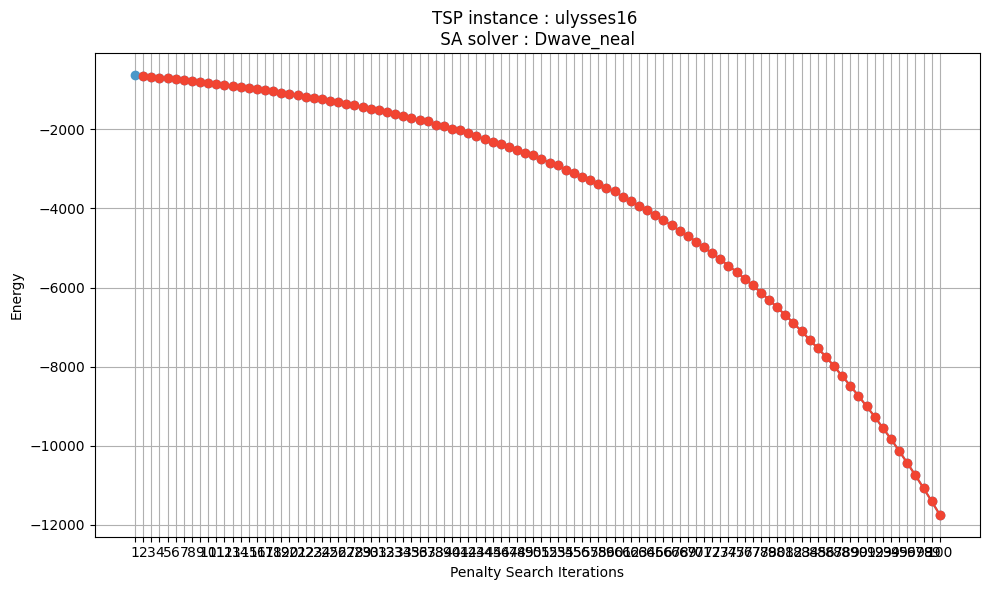

In [12]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 101))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list_all, marker='o', linestyle='-', color=plt.cm.Blues(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color=plt.cm.Reds(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n SA solver : Dwave_neal ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Energy')
plt.grid(True)
plt.xticks(iterations)
# plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [15]:
min_distance_list_all_pp = [] 
for i in min_distance_list_all:
    if i == None:
        min_distance_list_all_pp.append(i)
    else:
        min_distance_list_all_pp.append(100*i)



In [17]:
print(min_distance_list_all_pp)
# [None, 8743.886004264183, 7449.804974008655, 9527.22684678298, 8396.070993827661, 9058.454724587926, 8597.159086366439, 9938.891805708183, 10026.642720699183, 9635.619010829463, 8847.507370080411, 9505.690404028237, 10537.788985892572, 7668.0622642857825, 9980.865606597925, 10159.399990818796, 10314.488043500714, 11415.365771133529, 10010.484768056062, 9846.963606783464, 9656.552990839758, 10323.623030699362, 10245.22958635101, 10347.232229786852, 8449.47648160243, 10556.999495320493, 10530.076119146908, 10092.371484384936, 11065.315445965185, 10920.005932816708, 10333.431011794937, 9959.286184678698, 10785.683000219282, 10554.353951083564, 8987.277897327232, 9597.78138926038, 11328.560569519621, 11214.287308493793, 11665.2485382355, 9712.34370390542, 10765.242625199155, 10664.460657049738, 9135.974130725708, 9692.90037683275, 10103.516677916848, 10815.167549353315, 10733.995863629734, 9289.45879748046, 9330.560039430628, 10969.2211894868, 10177.390629898337, 10536.993460350543, 9424.112110605945, 9638.948663902936, 9280.46843956668, 8762.099991974956, 10738.10078019164, 10930.453741191177, 9755.449802787349, 10312.303773094147, 10731.669884511433, 7922.172866555275, 9934.204200192207, 9070.550124407559, 10135.219666943885, 10013.607371413782, 9889.635013610517, 10268.370359883958, 9475.366464775012, 9870.064780320754, 8810.20387254636, 10047.845738702366, 9684.034507234861, 10322.610697247808, 7331.73413919607, 9568.400829015494, 9102.39757509504, 10439.169790705082, 10038.270654248634, 10205.025426678012, 10665.750126242727, 8968.010031323336, 10358.545064865302, 9703.79484636383, 9192.015414228414, 9958.018220217271, 9941.761331057944, 9318.992766765823, 9445.181691036556, 9694.679486609883, 9537.394799425652, 8149.75655494013, 8896.085792928492, 10210.833799832068, 8514.589256819954, 8271.483790710377, 9411.02297643611, 9386.75653172632, 9780.253451134982, 10444.0145964258]

[None, 8743.886004264183, 7449.804974008655, 9527.22684678298, 8396.070993827661, 9058.454724587926, 8597.159086366439, 9938.891805708183, 10026.642720699183, 9635.619010829463, 8847.507370080411, 9505.690404028237, 10537.788985892572, 7668.0622642857825, 9980.865606597925, 10159.399990818796, 10314.488043500714, 11415.365771133529, 10010.484768056062, 9846.963606783464, 9656.552990839758, 10323.623030699362, 10245.22958635101, 10347.232229786852, 8449.47648160243, 10556.999495320493, 10530.076119146908, 10092.371484384936, 11065.315445965185, 10920.005932816708, 10333.431011794937, 9959.286184678698, 10785.683000219282, 10554.353951083564, 8987.277897327232, 9597.78138926038, 11328.560569519621, 11214.287308493793, 11665.2485382355, 9712.34370390542, 10765.242625199155, 10664.460657049738, 9135.974130725708, 9692.90037683275, 10103.516677916848, 10815.167549353315, 10733.995863629734, 9289.45879748046, 9330.560039430628, 10969.2211894868, 10177.390629898337, 10536.993460350543, 9424.1

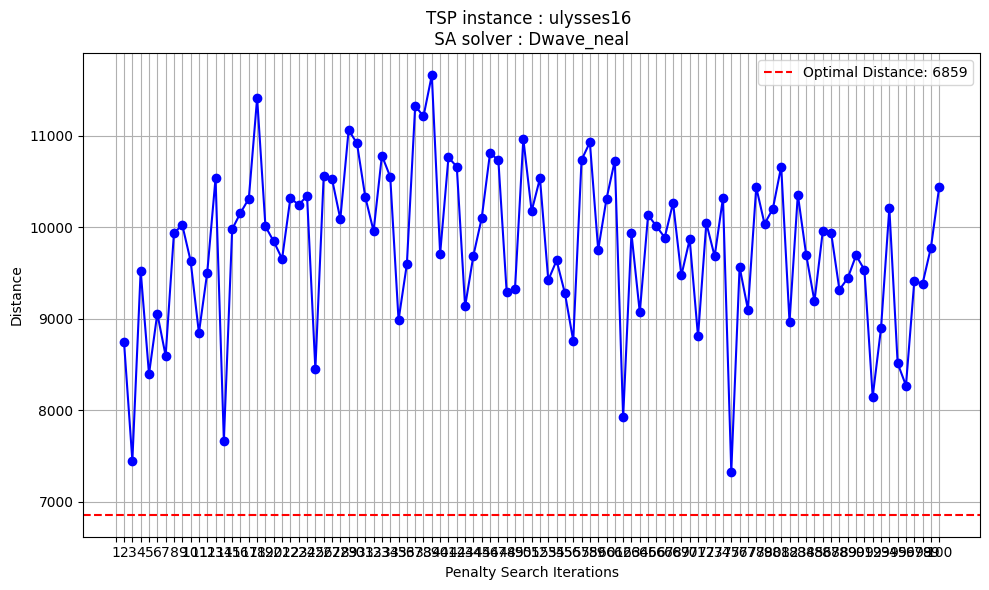

In [16]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 101))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_distance_list_all_pp, marker='o', linestyle='-', color='b') #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")
plt.axhline(y=6859, color='red', linestyle='--', label="Optimal Distance: 6859")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n SA solver : Dwave_neal ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Distance')
plt.grid(True)
plt.xticks(iterations)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
